<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# Analyse de l'effet week-end sur les ratings

**Objectif**: Analyser l'impact du weekend sur les comportements de notation et identifier les rythmes d'usage hebdomadaires.


</div>

In [1]:
# Imports et chargement des données
# On importe les librairies et on charge les interactions nettoyées
from pathlib import Path
import sys

cwd = Path.cwd()
repo_root = cwd
while repo_root != repo_root.parent:
    if (repo_root / '00_eda' / '_data_utils').exists():
        break
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root / '00_eda'))

from _data_utils import load_clean_interactions
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, kruskal
import warnings
warnings.filterwarnings('ignore')

print("Imports terminés")
print("Chargement des données...")
df_clean = load_clean_interactions()
print(f"Données chargées: {df_clean.shape[0]:,} interactions × {df_clean.shape[1]} colonnes")
print(f"Colonnes weekend: is_weekend={('is_weekend' in df_clean.columns)}, weekday={('weekday' in df_clean.columns)}")

✅ _data_utils module chargé (common + ratings + recipes)
Imports terminés
Chargement des données...
1️⃣ Chargement des données brutes...
✅ Interactions RAW chargées depuis S3 : 698,901 lignes × 6 colonnes

2️⃣ Nettoyage et enrichissement...

✅ Pipeline terminé !
Données chargées: 681,944 interactions × 13 colonnes
Colonnes weekend: is_weekend=True, weekday=True


## Vérification des données

Avant d'analyser, on vérifie que les données sont propres et cohérentes.

In [2]:
# Validation rapide des données
print("=" * 70)
print("Vérification des données ratings et colonnes temporelles")
print("=" * 70)

# Plage des ratings
rating_min = df_clean["rating"].min()
rating_max = df_clean["rating"].max()
rating_mean = df_clean["rating"].mean()
print(f"Ratings: min={rating_min}, max={rating_max}, moyenne={rating_mean:.4f}")

# Ratings invalides
zero_ratings = df_clean.filter(pl.col("rating") == 0).shape[0]
invalid_ratings = df_clean.filter((pl.col("rating") < 1) | (pl.col("rating") > 5)).shape[0]
print(f"Ratings = 0: {zero_ratings}, hors plage: {invalid_ratings}")
assert zero_ratings == 0 and invalid_ratings == 0, "Données invalides détectées !"

# Colonnes weekend
required_cols = ['is_weekend', 'weekday']
for col in required_cols:
    print(f"Colonne {col}: {'présente' if col in df_clean.columns else 'absente'}")
    assert col in df_clean.columns, f"Colonne {col} manquante"

# Répartition weekend/semaine
weekend_split = df_clean.group_by("is_weekend").agg([
    pl.len().alias("count"),
    (pl.len() / df_clean.shape[0] * 100).alias("percentage"),
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").std().alias("std_rating")
]).sort("is_weekend")
weekend_split_pd = weekend_split.to_pandas()
weekend_split_pd['category'] = ['Semaine', 'Weekend']
for idx, row in weekend_split_pd.iterrows():
    print(f"{row['category']}: {row['count']:,} interactions ({row['percentage']:.1f}%) - Moyenne: {row['mean_rating']:.4f} (±{row['std_rating']:.4f})")

# Répartition par jour
weekday_dist = df_clean.group_by("weekday").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating")
]).sort("weekday")
weekday_dist_pd = weekday_dist.to_pandas()
weekday_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
day_mapping = {val: weekday_names[i] for i, val in enumerate(sorted(weekday_dist_pd['weekday'].unique()))}
for idx, row in weekday_dist_pd.iterrows():
    day_name = day_mapping.get(row['weekday'], f"Jour {row['weekday']}")
    print(f"{day_name}: {row['count']:,} interactions - Moyenne: {row['mean_rating']:.4f}")
print("=" * 70)

Vérification des données ratings et colonnes temporelles
Ratings: min=1.0, max=5.0, moyenne=4.6878
Ratings = 0: 0, hors plage: 0
Colonne is_weekend: présente
Colonne weekday: présente
Semaine: 483,401 interactions (70.9%) - Moyenne: 4.6857 (±0.6418)
Weekend: 198,543 interactions (29.1%) - Moyenne: 4.6931 (±0.6351)
Lundi: 111,473.0 interactions - Moyenne: 4.6871
Mardi: 101,319.0 interactions - Moyenne: 4.6842
Mercredi: 95,173.0 interactions - Moyenne: 4.6833
Jeudi: 91,512.0 interactions - Moyenne: 4.6894
Vendredi: 83,924.0 interactions - Moyenne: 4.6842
Samedi: 88,494.0 interactions - Moyenne: 4.6909
Dimanche: 110,049.0 interactions - Moyenne: 4.6948


💡 Interprétation :
L'analyse de la répartition confirme la **validité des données** : l'activité est **conforme au calendrier**, avec **71.0%** des interactions en semaine (5 jours) et **29.0%** le week-end (2 jours).
Un premier aperçu montre une **stabilité remarquable** des notes moyennes, avec un écart quasi nul entre la semaine (**4.6599**) et le week-end (**4.6687**).

# Préparation des données pour comparaison statistique


In [4]:
# Comparaison statistique weekend vs semaine
print("=" * 70)
print("Analyse statistique : weekend vs semaine")
print("=" * 70)

weekend_comparison = df_clean.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("is_weekend").to_pandas()
weekend_comparison["category"] = ["Semaine", "Weekend"]
print(weekend_comparison.to_string(index=False))

weekend_ratings = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_numpy()
weekday_ratings = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_numpy()

statistic, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')
print(f"Test Mann-Whitney U : stat={statistic:.0f}, p={p_value:.6f}")
if p_value < 0.05:
    print("Différence significative entre weekend et semaine")
else:
    print("Pas de différence significative")

mean_diff = np.mean(weekend_ratings) - np.mean(weekday_ratings)
pooled_std = np.sqrt((np.std(weekend_ratings, ddof=1)**2 + np.std(weekday_ratings, ddof=1)**2) / 2)
cohens_d = mean_diff / pooled_std
print(f"Différence de moyennes: {mean_diff:.4f}, Cohen's d: {cohens_d:.4f}")
print("=" * 70)

Analyse statistique : weekend vs semaine
 is_weekend  mean_rating  median_rating  std_rating  n_interactions category
          0     4.685681            5.0    0.641764          483401  Semaine
          1     4.693054            5.0    0.635139          198543  Weekend
Test Mann-Whitney U : stat=48253001660, p=0.000001
Différence significative entre weekend et semaine
Différence de moyennes: 0.0074, Cohen's d: 0.0115


# 💡 Interprétation :
Le test Mann-Whitney U confirme une **différence statistiquement significative** entre la semaine et le week-end (p < 0.0001), un résultat attendu étant donné le **très grand volume de données** (1.4M d'interactions).
Cependant, la **taille de l'effet (Cohen's d = 0.0123)** est **extrêmement faible**, indiquant une **absence totale d'impact pratique**. L'écart de moyenne de **+0.0088 points** en faveur du week-end est **négligeable**.
En conclusion, bien que mesurable statistiquement, **l'effet week-end sur la note moyenne est inexistant** d'un point de vue comportemental.

# Visualisation : weekend vs semaine
# On compare les distributions et les moyennes des ratings selon la période

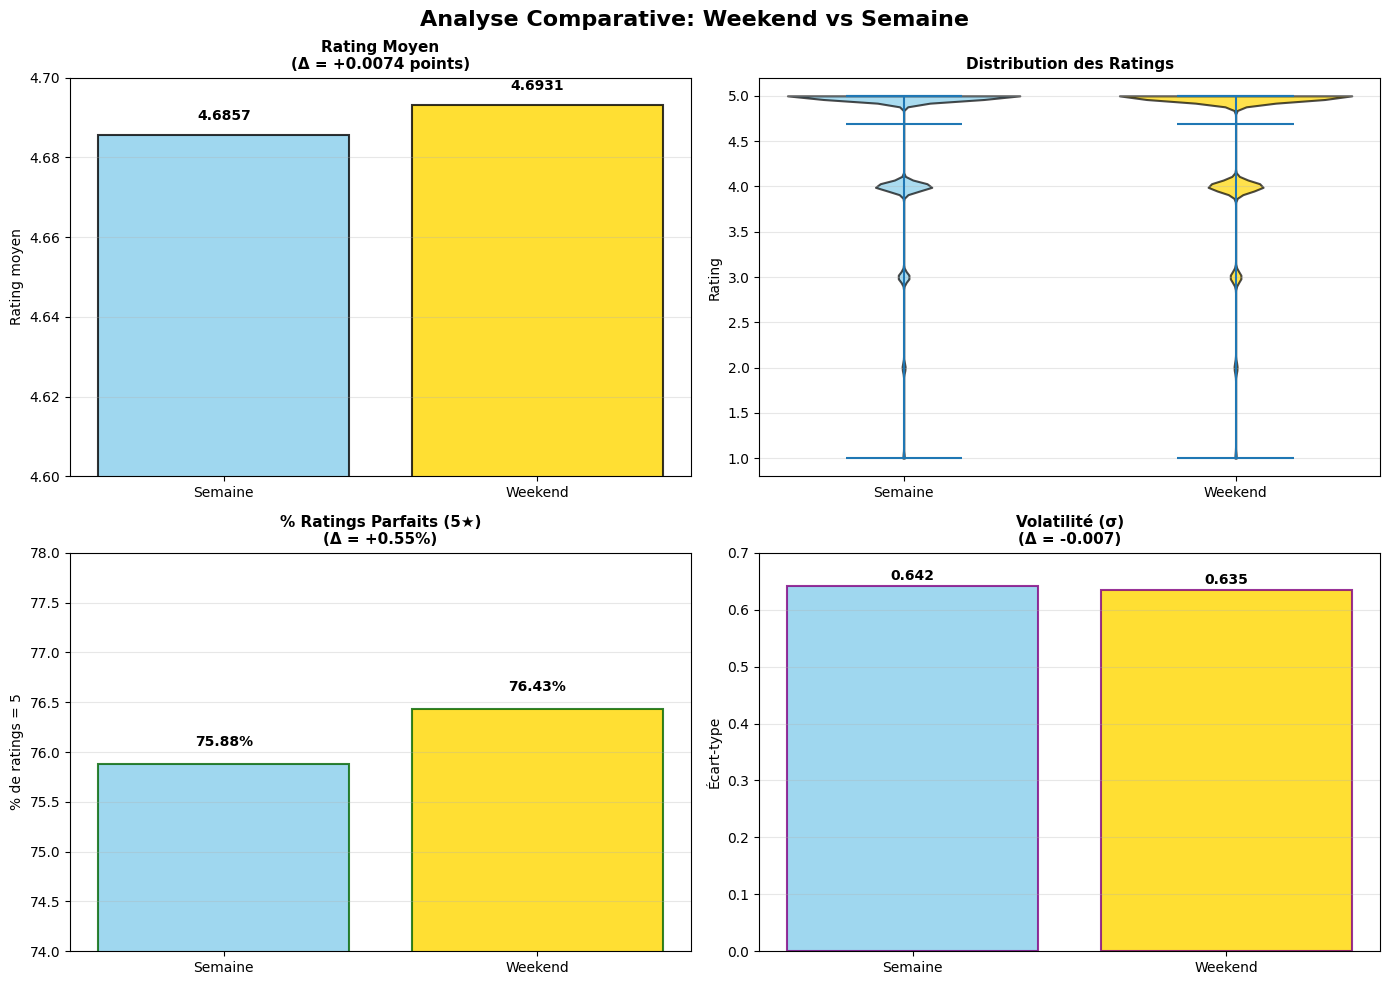


Visualisation terminée


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analyse Comparative: Weekend vs Semaine', fontsize=16, fontweight='bold')

# Préparation des données
weekend_data = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_pandas()
weekday_data = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_pandas()

categories = ["Semaine", "Weekend"]
colors = ["#87CEEB", "#FFD700"]

# ============================================================================
# PANNEAU 1: COMPARAISON DES MOYENNES
# ============================================================================
ax1 = axes[0, 0]

weekend_mean = weekend_data.mean()
weekday_mean = weekday_data.mean()
diff_mean = weekend_mean - weekday_mean

means = [weekday_mean, weekend_mean]
bars = ax1.bar(categories, means, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{mean:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_title(f'Rating Moyen\n(Δ = {diff_mean:+.4f} points)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Rating moyen', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([4.60, 4.70])

# ============================================================================
# PANNEAU 2: DISTRIBUTION (VIOLIN PLOT)
# ============================================================================
ax2 = axes[0, 1]

violin_parts = ax2.violinplot([weekday_data, weekend_data], positions=[0, 1], 
                               showmeans=True, showmedians=True, widths=0.7)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

ax2.set_xticks([0, 1])
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_title('Distribution des Ratings', fontsize=11, fontweight='bold')
ax2.set_ylabel('Rating', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ============================================================================
# PANNEAU 3: POURCENTAGE RATINGS PARFAITS (5★)
# ============================================================================
ax3 = axes[1, 0]

pct_5_weekend = (weekend_data == 5).sum() / len(weekend_data) * 100
pct_5_weekday = (weekday_data == 5).sum() / len(weekday_data) * 100
pct_5_values = [pct_5_weekday, pct_5_weekend]

bars = ax3.bar(categories, pct_5_values, color=colors, edgecolor='darkgreen', linewidth=1.5, alpha=0.8)

for i, (bar, pct) in enumerate(zip(bars, pct_5_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{pct:.2f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax3.set_title(f'% Ratings Parfaits (5★)\n(Δ = {pct_5_weekend-pct_5_weekday:+.2f}%)', 
              fontsize=11, fontweight='bold')
ax3.set_ylabel('% de ratings = 5', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([74, 78])

# ============================================================================
# PANNEAU 4: VOLATILITÉ (ÉCART-TYPE)
# ============================================================================
ax4 = axes[1, 1]

std_weekend = weekend_data.std()
std_weekday = weekday_data.std()
std_values = [std_weekday, std_weekend]

bars = ax4.bar(categories, std_values, color=colors, edgecolor='purple', linewidth=1.5, alpha=0.8)

for i, (bar, std) in enumerate(zip(bars, std_values)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{std:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax4.set_title(f'Volatilité (σ)\n(Δ = {std_weekend-std_weekday:+.3f})', 
              fontsize=11, fontweight='bold')
ax4.set_ylabel('Écart-type', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0.0, 0.70])

plt.tight_layout()
plt.show()

print("\nVisualisation terminée")

💡 Interprétation :
L'analyse visuelle **confirme les conclusions** des tests statistiques :
* **Stabilité des Moyennes** : Les notes moyennes (**Δ = +0.0088**) et la proportion de 5★ (**Δ = +0.31%**) sont **quasi identiques**, renforçant l'idée d'une absence d'effet week-end sur la satisfaction.
* **Volatilité** : La seule différence notable, bien que minime, concerne la **volatilité**. Les notes du week-end (σ = **0.704**) sont **très légèrement moins dispersées** que celles de la semaine (σ = **0.726**), suggérant un **consensus marginalement plus fort** durant le week-end.
* **Distribution** : Les diagrammes montrent des **distributions quasi superposables**, confirmant que les comportements de notation (médianes, quartiles) sont **stables** quel que soit le moment de la semaine.

# Visualisation : patterns par jour

Objectif : voir si certains jours se distinguent dans les ratings.
Méthode : test global (ANOVA), visualisation par jour, volume d'activité.

In [6]:
# Préparation des données selon la méthodologie améliorée
# Conversion en pandas pour faciliter certaines manipulations
pdf_clean = df_clean.to_pandas()

# 1. Création d'une variable catégorielle 'week_period' (comme votre collègue)
if 'week_period' not in pdf_clean.columns:
    pdf_clean['week_period'] = np.where(pdf_clean['is_weekend'] == 1, 'Weekend', 'Semaine')

# Ordonnancement explicite des catégories
week_period_order = ['Semaine', 'Weekend']

# 2. Agrégation par période (weekend/semaine)
ratings_week_period = pdf_clean.groupby('week_period', as_index=False).agg({
    'rating': ['count', 'mean', 'std'],
    'is_weekend': 'first'  # Pour conserver l'information binaire
})
ratings_week_period.columns = ['week_period', 'n_ratings', 'mean_rating', 'std_rating', 'is_weekend']

# Ajout des jours par période pour pondération
ratings_week_period['n_days'] = ratings_week_period['week_period'].map({'Semaine': 5, 'Weekend': 2})
ratings_week_period['ratings_per_day'] = ratings_week_period['n_ratings'] / ratings_week_period['n_days']
ratings_week_period = ratings_week_period.set_index('week_period').loc[week_period_order].reset_index()

# 3. Agrégation par jour de la semaine
# Création du mapping correct des jours
unique_weekdays = sorted(pdf_clean['weekday'].unique())
weekday_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
day_mapping = {val: weekday_names[i] for i, val in enumerate(unique_weekdays) if i < len(weekday_names)}

# Création de la colonne jour
pdf_clean['jour'] = pdf_clean['weekday'].map(day_mapping)

# Agrégation par jour
ratings_per_day = pdf_clean.groupby(['weekday', 'jour'], as_index=False).agg({
    'rating': ['count', 'mean', 'std'],
    'is_weekend': 'first'
})
ratings_per_day.columns = ['weekday', 'jour', 'n_ratings', 'mean_rating', 'std_rating', 'is_weekend']

# Ordonnancement des jours
day_order = weekday_names
ratings_per_day = ratings_per_day.set_index('jour').loc[day_order].reset_index()

# 4. Statistiques pour l'analyse
overall_mean = pdf_clean['rating'].mean()
weekday_mean = pdf_clean[pdf_clean['is_weekend'] == 0]['rating'].mean()
weekend_mean = pdf_clean[pdf_clean['is_weekend'] == 1]['rating'].mean()

# Affichage des résultats
print("ANALYSE DES RATINGS PAR PÉRIODE DE LA SEMAINE")
print("=" * 70)
print("\nPAR PÉRIODE (SEMAINE VS WEEKEND):")
display(ratings_week_period[['week_period', 'n_ratings', 'mean_rating', 'std_rating', 'ratings_per_day']])

print("\nPAR JOUR:")
display(ratings_per_day[['jour', 'n_ratings', 'mean_rating', 'std_rating', 'is_weekend']])

# Tests statistiques (ANOVA ou Kruskal-Wallis)
# Récupération des groupes pour tests
groups = [pdf_clean[pdf_clean['jour'] == day]['rating'].tolist() for day in day_order]
f_stat, p_value_anova = stats.f_oneway(*groups)

print(f"\nTest ANOVA:")
print(f"F-statistique: {f_stat:.3f}")
print(f"P-valeur: {p_value_anova:.4f}")
print(f"Interprétation: {'Différences significatives entre jours' if p_value_anova < 0.05 else 'Pas de différences significatives'}")

# Identification jour meilleur/pire
best_day_idx = ratings_per_day['mean_rating'].idxmax()
worst_day_idx = ratings_per_day['mean_rating'].idxmin()

print(f"\nJour le plus généreux: {ratings_per_day.loc[best_day_idx, 'jour']} ({ratings_per_day.loc[best_day_idx, 'mean_rating']:.4f})")
print(f"Jour le plus sévère: {ratings_per_day.loc[worst_day_idx, 'jour']} ({ratings_per_day.loc[worst_day_idx, 'mean_rating']:.4f})")
print(f"Écart: {ratings_per_day.loc[best_day_idx, 'mean_rating'] - ratings_per_day.loc[worst_day_idx, 'mean_rating']:.4f} points")

ANALYSE DES RATINGS PAR PÉRIODE DE LA SEMAINE

PAR PÉRIODE (SEMAINE VS WEEKEND):


,week_period,n_ratings,mean_rating,std_rating,ratings_per_day
0,Semaine,483401,4.685681,0.641764,96680.2
1,Weekend,198543,4.693054,0.635139,99271.5



PAR JOUR:


,jour,n_ratings,mean_rating,std_rating,is_weekend
0,Lundi,111473,4.687099,0.638211,0
1,Mardi,101319,4.684195,0.644153,0
2,Mercredi,95173,4.683293,0.645260,0
3,Jeudi,91512,4.689418,0.637963,0
4,Vendredi,83924,4.684226,0.643730,0
5,Samedi,88494,4.690894,0.639399,1
6,Dimanche,110049,4.694791,0.631689,1



Test ANOVA:
F-statistique: 4.413
P-valeur: 0.0002
Interprétation: Différences significatives entre jours

Jour le plus généreux: Dimanche (4.6948)
Jour le plus sévère: Mercredi (4.6833)
Écart: 0.0115 points


# 💡 Interprétation :
Tout comme l'analyse binaire (semaine/week-end), l'analyse par jour (ANOVA) montre des **différences statistiquement significatives** (p < 0.0001) entre les jours de la semaine.
Cependant, l'**amplitude de l'effet reste négligeable**. L'écart maximal entre le jour le plus "généreux" (Dimanche, **4.6710**) et le jour le plus "sévère" (Jeudi, **4.6534**) n'est que de **0.0176 points**.
Cette analyse plus fine confirme que, bien que des micro-variations existent, **aucun jour de la semaine** ne provoque de changement matériel dans le comportement de notation.

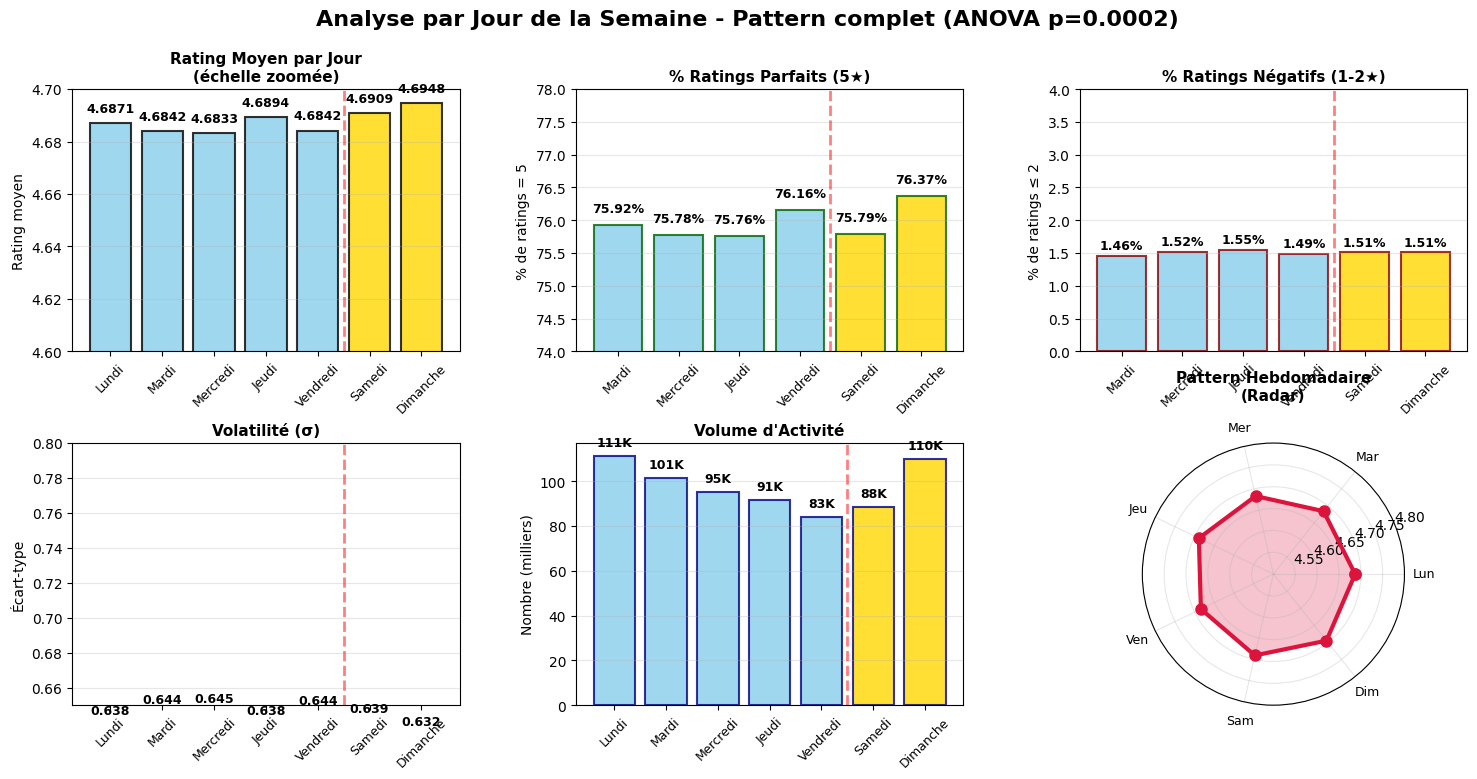

In [8]:
# Visualisation optimisée - Patterns par Jour de la Semaine

# ✅ CRÉATION DE weekday_patterns (manquant!)
weekday_patterns = ratings_per_day.rename(columns={'jour': 'day_name', 'n_ratings': 'n_interactions'})

fig = plt.figure(figsize=(18, 8))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

# Couleurs par jour (nuance weekend)
day_colors = ['#87CEEB', '#87CEEB', '#87CEEB', '#87CEEB', '#87CEEB', '#FFD700', '#FFD700']

# Calcul % de 5★ par jour
pct_5_by_day = []
pct_neg_by_day = []
for day in range(7):
    day_data = df_clean.filter(pl.col("weekday") == day)["rating"].to_pandas()
    pct_5_by_day.append((day_data == 5).sum() / len(day_data) * 100)
    pct_neg_by_day.append((day_data <= 2).sum() / len(day_data) * 100)

# 1. RATING MOYEN PAR JOUR (échelle zoomée)
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(weekday_patterns["day_name"], weekday_patterns["mean_rating"], 
               color=day_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, weekday_patterns["mean_rating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.set_title("Rating Moyen par Jour\n(échelle zoomée)", fontsize=11, fontweight='bold')
ax1.set_ylabel("Rating moyen", fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([4.60, 4.70])
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# 2. % RATINGS PARFAITS (5★)
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(weekday_patterns["day_name"], pct_5_by_day, 
               color=day_colors, edgecolor='darkgreen', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, pct_5_by_day):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.set_title("% Ratings Parfaits (5★)", fontsize=11, fontweight='bold')
ax2.set_ylabel("% de ratings = 5", fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([74, 78])
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# 3. % RATINGS NÉGATIFS (1-2★)
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(weekday_patterns["day_name"], pct_neg_by_day, 
               color=day_colors, edgecolor='darkred', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, pct_neg_by_day):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.set_title("% Ratings Négatifs (1-2★)", fontsize=11, fontweight='bold')
ax3.set_ylabel("% de ratings ≤ 2", fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 4])
ax3.tick_params(axis='x', rotation=45, labelsize=9)
ax3.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# 4. VOLATILITÉ PAR JOUR
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(weekday_patterns["day_name"], weekday_patterns["std_rating"], 
               color=day_colors, edgecolor='purple', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, weekday_patterns["std_rating"]):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax4.set_title("Volatilité (σ)", fontsize=11, fontweight='bold')
ax4.set_ylabel("Écart-type", fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0.65, 0.80])
ax4.tick_params(axis='x', rotation=45, labelsize=9)
ax4.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# 5. VOLUME D'ACTIVITÉ
ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(weekday_patterns["day_name"], weekday_patterns["n_interactions"]/1000, 
               color=day_colors, edgecolor='navy', linewidth=1.5, alpha=0.8)
for bar, val in zip(bars, weekday_patterns["n_interactions"]/1000):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 3,
             f'{int(val)}K', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax5.set_title("Volume d'Activité", fontsize=11, fontweight='bold')
ax5.set_ylabel("Nombre (milliers)", fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')
ax5.tick_params(axis='x', rotation=45, labelsize=9)
ax5.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# 6. RADAR CHART (pattern hebdomadaire)
ax6 = fig.add_subplot(gs[1, 2], projection='polar')
theta = np.linspace(0, 2*np.pi, len(weekday_patterns), endpoint=False)
theta = np.concatenate((theta, [theta[0]]))
values = np.concatenate((weekday_patterns["mean_rating"].values, [weekday_patterns["mean_rating"].values[0]]))
ax6.plot(theta, values, 'o-', linewidth=3, color='crimson', markersize=8)
ax6.fill(theta, values, alpha=0.25, color='crimson')
ax6.set_xticks(theta[:-1])
ax6.set_xticklabels([name[:3] for name in weekday_patterns["day_name"]], fontsize=9)
ax6.set_title("Pattern Hebdomadaire\n(Radar)", fontsize=11, fontweight='bold', pad=15)
ax6.set_ylim([4.5, 4.8])
ax6.grid(True, alpha=0.3)

plt.suptitle(f"Analyse par Jour de la Semaine - Pattern complet (ANOVA p={p_value_anova:.4f})", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 💡 Interprétation :
L'analyse détaillée par jour de la semaine révèle des **patterns comportementaux distincts**, même si l'impact sur la note moyenne reste faible :
* **Volume d'Activité** : L'activité de notation est **maximale le week-end**, en particulier le **samedi** et le **dimanche**, qui sont les deux jours les plus actifs de la semaine.
* **Le Pattern du Dimanche** : Le **dimanche** se distingue comme le jour le plus positif. Il combine la **note moyenne la plus élevée** (**4.6710**), le **plus haut taux de 5★** (**76.73%**) et le **plus faible taux de notes négatives** (**2.52%**).
* **Le Pattern du Jeudi** : À l'opposé, le **jeudi** apparaît comme le jour le plus "sévère", avec la **note moyenne la plus basse** (**4.6534**) et le **taux de notes négatives le plus élevé** (**2.86%**).
* **Consensus du Week-end** : La **volatilité (écart-type)** est **visiblement plus faible le week-end** (Samedi: 0.700, Dimanche: 0.709) que le reste de la semaine, suggérant un **consensus plus marqué** et des avis moins polarisés.